# Pre process

In [3]:
# Download OSM data
import os

import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import shapely as shp

import createLinksAndNodes as cln
import getPopulation as gp
import setActionsAndTransitions as actrans


def createBoundingBox(area={'north': 33.58, 'south': 33.53, 'east': 133.58, 'west': 133.52}):
    # create a Bounding Box
    # returns a shapely geometry
    bbox = shp.geometry.box(area["west"], area["south"], area["east"], area["north"])
    return bbox


def createGraph(area={'north': 33.58, 'south': 33.53, 'east': 133.58, 'west': 133.52}, 
                crs='EPSG:6690', ntype='drive', plot=False):
    # NEW AREA (Aug, 2021)
    maprange = area  # Degree 1.0 = 111km. 2.22km x 4.44km square.
    # Obtain the roadmap data from OpenStreetMap by using OSMNX
    G = ox.graph_from_bbox(maprange['north'], maprange['south'], maprange['east'], maprange['west'],
                           network_type=ntype, simplify=True)
    G_projected = ox.project_graph(G, to_crs=crs)
    # Simplify topology
    G_simple = ox.simplification.consolidate_intersections(G_projected, tolerance=10, rebuild_graph=True,
                                                           dead_ends=False, reconnect_edges=True)
    # save the OSM data as Geopackage
    ox.io.save_graph_geopackage(G_simple, filepath='./tmp/graph.gpkg')
    print(f"""
          The graph was saved as 'graph.gpkg' with projection {crs}.
          This is a simplified {ntype} type OSM network.
          """)
    # Draw a map
    if plot:
        ox.plot_graph(G_simple, bgcolor='white', node_color='red', edge_color='black')
    # Create edges file
    edges = gpd.read_file('./tmp/graph.gpkg', layer='edges')
    edges.to_file('./tmp/edges.shp')
    nedges = G.number_of_edges()
    print(f'{nedges} edges in graph. The edges file was saved as ESRI shapefile')
    # create database of links and edges
    cln.main()
    print('Database created!')
    if plot:
        cln.plotNetwork()
    return G_simple


def getPrefShelters(pref_code=39, crs='EPSG:6690', filter=True):
    rootfolder = "/Volumes/Pegasus32/data/"
    datafolder = u"PAREA_Hazard_2018/data/世界測地系"
    areafile = f"{pref_code:02d}/PHRP{pref_code:02d}18.shp"
    path = os.path.join(rootfolder, datafolder, areafile)
    shelters_gc = gpd.read_file(path, encoding='shift_jis')
    shelters = shelters_gc.to_crs(crs)
    if filter:
        shelters = shelters[shelters['TUNAMI'] == 1]
    return shelters


def getAreaShelters(area={'north': 33.58, 'south': 33.53, 'east': 133.58, 'west': 133.52},
                    pref_code=39, crs='EPSG:6690'):
    bbox = createBoundingBox(area)
    bbox_gdf = gpd.GeoSeries(bbox)
    bbox_gdf.set_crs('EPSG:4326', inplace=True)
    bbox_gdf = bbox_gdf.to_crs(crs)
    poly = shp.geometry.shape(bbox_gdf[0])
    shelters = getPrefShelters(pref_code, crs)
    gs = gpd.GeoSeries(shelters.geometry)
    sh_in_area = shelters[gs.within(poly)]
    return sh_in_area


def pointsWithinPolygon(poly):
    # Get the nodes within a polygon
    df = pd.read_csv('./data/nodesdb.csv')
    nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.coord_x, df.coord_y))
    gs = gpd.GeoSeries(nodes.geometry)
    ninarea = nodes[gs.within(poly)]
    return ninarea

def fixLinksDBAndNodesDB(shelters):
    # fixes the nodesdb to add shelters as nodes
    # requires 'shelters' geodataframe
    # the 'nodesdb.csv' was created with 'createLinksAndNodes.py'
    nodesnp = np.loadtxt('./tmp/nodesdb0.csv', delimiter=',')
    linksdb = np.loadtxt('./tmp/linksdb0.csv', delimiter=',')
    # create a numpy array for nodesdb
    nodesdb = np.zeros((nodesnp.shape[0], nodesnp.shape[1] + 2))
    nodesdb[:, :3] = nodesnp[:, :3]
    nodesdb[:, 4] += 1 #general reward
    # create a pandas then numpy for shelter coords
    sheltersdb = pd.DataFrame()
    for i, g in zip(shelters.index, shelters['geometry']):
        x, y = g.coords.xy
        sheltersdb.loc[i, 'x'], sheltersdb.loc[i, 'y'] = x[0], y[0]
    sheltersdb = sheltersdb.to_numpy()
    for i in range(sheltersdb.shape[0]):
        x0, y0 = sheltersdb[i, :]
        dist = ((nodesnp[:, 1] - x0) ** 2 + (nodesnp[:, 2] - y0) ** 2) ** 0.5
        indx = np.argmin(dist)
        nodesdb[indx, 3] = 1
        nodesdb[indx, 4] = 1000 #shelter reward
    # correcting links length = 0 to = 2
    linksdb[:, 3][np.where(linksdb[:, 3] == 0)] = 2
    np.savetxt("./data/nodesdb.csv", nodesdb, delimiter=",",
               header="number,coord_x,coord_y,evacuation,reward", fmt="%d,%.6f,%.6f,%d,%d")
    np.savetxt("./data/linksdb.csv", linksdb, delimiter=",",
               header="number,node1,node2,length,width", fmt="%d,%d,%d,%d,%d")
    return


def appendAgents(agentsdb, pop, index, poly):
    # Get a polygon
    poly_pop = pop.TotalPop.to_list()[index]
    ninarea = pointsWithinPolygon(poly)
    if ninarea.shape[0] == 0:
        return agentsdb
    pop_per_node = int(poly_pop / ninarea.shape[0])
    from_row = np.trim_zeros(agentsdb[:, 4], 'b').shape[0]
    to_row = from_row + ninarea.shape[0] * pop_per_node  # +1?
    n = ninarea["# number"].to_list()
    nr = np.repeat(n, pop_per_node)
    agentsdb[from_row:to_row, 4] = nr
    return agentsdb
    

In [6]:
case = 'kochi'
# Set Prefecture / Area of Interest / working CRS
pref_code = 39
aos_gdf = gpd.read_file(f'./case/{case}/aos.geojson')
area = {'north':aos_gdf.total_bounds[3], 'south':aos_gdf.total_bounds[1], 'east':aos_gdf.total_bounds[2], 'west': aos_gdf.total_bounds[0]}
# area = {'north': 33.58, 'south': 33.53,'east': 133.58, 'west': 133.52}
crs = 6690

# Get a Bounding Box of the area
bbox = createBoundingBox(area=area)
aos = gpd.GeoSeries([bbox]).to_json()

# Get Population in the Area of Study (Census Data)
pop = gp.getPopulationArea(pref_code=pref_code, aos=aos, crs=crs)
    
# Create a Graph object
G = createGraph(area=area,crs=crs,ntype='drive',plot=False)

# Create a Shelter GeoDataframe
shelters = getAreaShelters(area=area,pref_code=pref_code,crs=crs)

# Fix the nodesdb
fixLinksDBAndNodesDB(shelters)
actrans.setMatrices()
# Create the agentsdb
agentsdb = np.zeros((pop.TotalPop.sum(), 5))
for i, g in enumerate(pop.geometry.to_list()):
    agentsdb = appendAgents(agentsdb, pop=pop, index=i, poly=g)
last = np.trim_zeros(agentsdb[:, 4], 'b').shape[0]
agentsdb = agentsdb[:last, :]
np.savetxt("./data/agentsdb.csv", agentsdb, delimiter=",",
            header="age,gender,hhType,hhId,Node", fmt="%d,%d,%d,%d,%d")


          The graph was saved as 'graph.gpkg' with projection 6690.
          This is a simplified drive type OSM network.
          
11452 edges in graph. The edges file was saved as ESRI shapefile
Database created!
Actions and Transitions DB saved!


In [19]:
case = 'arahama'
# Set Prefecture / Area of Interest / working CRS
pref_code = 4
aos_gdf = gpd.read_file(f'./case/{case}/aos.geojson')
area = {'north':aos_gdf.total_bounds[3], 'south':aos_gdf.total_bounds[1], 'east':aos_gdf.total_bounds[2], 'west': aos_gdf.total_bounds[0]}
# area = {'north': 33.58, 'south': 33.53,'east': 133.58, 'west': 133.52}
crs = 6690

# Get a Bounding Box of the area
bbox = createBoundingBox(area=area)
aos = gpd.GeoSeries([bbox]).to_json()

# Get Population in the Area of Study (Census Data)
pop = gp.getPopulationArea(pref_code=pref_code, aos=aos, crs=crs)
    
# Create a Graph object
G = createGraph(area=area,crs=crs,ntype='drive',plot=False)

# Create a Shelter GeoDataframe
shelters = getAreaShelters(area=area,pref_code=pref_code,crs=crs)
if shelters.empty:
    print('There are no shelters in the area. Select one node')


          The graph was saved as 'graph.gpkg' with projection 6690.
          This is a simplified drive type OSM network.
          
264 edges in graph. The edges file was saved as ESRI shapefile
Database created!
There are no shelters in the area. Select one node


In [ ]:
shelters_id = [ 337 ]
all_nodes = np.loadtxt('./tmp/nodesdb0.csv',delimiter=',')
shelters = np.where(all_nodes[:,0] == shelters_id)
shelteres

In [ ]:
# Fix the nodesdb
fixLinksDBAndNodesDB(shelters)
actrans.setMatrices()
# Create the agentsdb
agentsdb = np.zeros((pop.TotalPop.sum(), 5))
for i, g in enumerate(pop.geometry.to_list()):
    agentsdb = appendAgents(agentsdb, pop=pop, index=i, poly=g)
last = np.trim_zeros(agentsdb[:, 4], 'b').shape[0]
agentsdb = agentsdb[:last, :]
np.savetxt("./data/agentsdb.csv", agentsdb, delimiter=",",
            header="age,gender,hhType,hhId,Node", fmt="%d,%d,%d,%d,%d")

# Check ouptuts


In [6]:
import geopandas as gpd
import pandas as pd

In [22]:
nodes.shape, edges.shape

((410, 6), (449, 5))

In [24]:
410*(3**112)

4643944267729832249093551908447392521437105507432744102472408382607515753269545742511453909389613215292675265508204368371992692588703364828379433977695033045095637714950679978576562808031638363597909713484149503241410242032246547012453695772078757164023077933126621101108217433273586773997415101252990780838137966890645555779957440105588616784924200844505804531689469029166975967342136190592110973181433143064560415193038723512974496281882398147518032688712321583350077562739884006274649385764761707035154158688915706761203582859525994514677822666137717539863120408234175688665048099812868873846050287263864082991319442031583142676572084059663053224966144639875522046215817945356369577954854214173063265687443204233663466508525437258619441150236180514233586491276986377368628570690909083539362903320600383636665651100049565560516065312629635224774656991995359131804340239980121295969173433695417861612624287979332389142082975101262495727417709705295359929797180713305598665691474807283483485577071758

In [28]:
13558*(3**3844)

1535673082484904039834399433529993848918153084628613281495632020765675575190939053096836392768399413974099786579517922594816510393113176105930935752916811171351381857056129735354659476860803730089279509644343877193830245401785333765727980665313263161703046112617822655825005169763982670289193998604586561136670111100082254762552755437843182106585422318288041410747459051157216101590845913952386355473021233016324636809444366180217273672921013514245109443745406244562447599893349935538334057858503395706893172768398028104107272595352522771463461456280370107450346012069242780168798100908850638819628043773743152126739243782053762156316202821485650624977829000669081168355952675686381920436875937457521750150984267390244128754209460447618594710119564278340950381676423934252777223449447447673821518127334146374290558478401756338279922280698355960426702426767636075829347438381719134896342766196157935798633173083507037365569779912754071148105592882546207071419272588073105041693780864320718758474486314

In [7]:
agents = pd.read_csv('./data/agentsdb.csv',header=0,names=["age","gender","hhType","hhId","Node"])
agents.head()

,age,gender,hhType,hhId,Node
0,0,0,0,0,380
1,0,0,0,0,381
2,0,0,0,0,402
3,0,0,0,0,404
4,0,0,0,0,405


In [8]:
edges = pd.read_csv('./data/linksdb.csv',header=0,names=['number','node1','node2','length','width'])
edges.head()

,number,node1,node2,length,width
0,0,0,1,3,3
1,1,1,2,6,3
2,2,2,3,59,3
3,3,3,4,103,3
4,4,4,5,43,3


In [13]:
nodes = pd.read_csv('./data/nodesdb.csv',header=0,names=['number','coord_x','coord_y','evacuation','reward'])
nodes.head()

,number,coord_x,coord_y,evacuation,reward
0,0,1024166.65,4247349.54,0,1
1,1,1024167.69,4247346.70,0,1
2,2,1024172.31,4247341.54,0,1
3,3,1024222.61,4247309.37,0,1
4,4,1024180.41,4247215.16,0,1


In [14]:
n_gdf = gpd.GeoDataFrame(nodes,geometry=gpd.points_from_xy(x=nodes['coord_x'],y=nodes['coord_y']),crs='EPSG:6690')
n_gdf.explore()

In [15]:
shelter_nodesdb = nodes[nodes['evacuation']==1]

In [16]:
sh_gdf = gpd.GeoDataFrame(shelter_nodesdb,geometry=gpd.points_from_xy(x=shelter_nodesdb['coord_x'],y=shelter_nodesdb['coord_y']),crs='EPSG:6690')
sh_gdf.explore()

In [13]:
actions = pd.read_csv('./data/actionsdb.csv',header=None,names=['currentNode','NoNodesTarget','e1','e2','e3','e4','e5','e6','e7','e8','e9','e10'])
transitions = pd.read_csv('./data/transitionsdb.csv',header=None,names=['currentNode','NoNodesTarget','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10'])

In [14]:
actions.head()

,currentNode,NoNodesTarget,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
0,0,6,0,16,22,15,21,29,0,0,0,0
1,1,2,1,0,0,0,0,0,0,0,0,0
2,2,2,2,1,0,0,0,0,0,0,0,0
3,3,2,3,2,0,0,0,0,0,0,0,0
4,4,2,4,3,0,0,0,0,0,0,0,0


In [15]:
transitions.head()

,currentNode,NoNodesTarget,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10
0,0,6,1,16,21,15,20,28,0,0,0,0
1,1,2,2,0,0,0,0,0,0,0,0,0
2,2,2,3,1,0,0,0,0,0,0,0,0
3,3,2,4,2,0,0,0,0,0,0,0,0
4,4,2,5,3,0,0,0,0,0,0,0,0


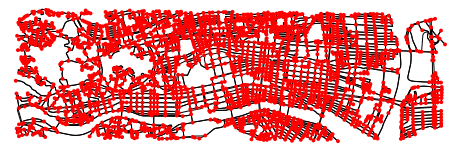

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
ox.plot_graph(G, bgcolor='white', node_color='red', edge_color='black')

In [17]:
import matplotlib.pyplot as plt

pedDB = np.loadtxt('./data/agentsdb.csv',delimiter=',')
numPedestrian = pedDB.shape[0]
ag = pedDB[:numPedestrian,4]
hist, bin_edges = np.histogram(ag,density=False)
norm = plt.Normalize()
colors = plt.cm.jet(norm(hist))
ag_unique = np.unique(ag.astype(np.int64))
ag_unique.shape
colors

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.12333966, 1.        , 0.84440228, 1.        ],
       [0.46489564, 1.        , 0.5028463 , 1.        ],
       [0.        , 0.80196078, 1.        , 1.        ],
       [0.78115117, 1.        , 0.18659077, 1.        ],
       [0.        , 0.69215686, 1.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ],
       [0.92780749, 0.01525054, 0.        , 1.        ],
       [0.81910183, 1.        , 0.1486401 , 1.        ],
       [1.        , 0.21859114, 0.        , 1.        ]])

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')

linksdb = np.loadtxt('./data/linksdb.csv',delimiter=',')
nodesdb = np.loadtxt('./data/nodesdb.csv',delimiter=',')
pedDB = np.loadtxt('./data/agentsdb.csv',delimiter=',')
numPedestrian = pedDB.shape[0]
transLinkdb = np.loadtxt('./data/actionsdb.csv',delimiter=',')

colorNode = ["b","r"] 
plt.figure(num="Network",figsize=(10,10))
for i in range(linksdb.shape[0]):
    plt.plot([nodesdb[int(linksdb[i,1]),1], nodesdb[int(linksdb[i,2]),1]],[nodesdb[int(linksdb[i,1]),2], nodesdb[int(linksdb[i,2]),2]], c='k', lw=1)
    # plt.text(0.5*(nodesdb[int(linksdb[i,1]),1] + nodesdb[int(linksdb[i,2]),1]) , 0.5*(nodesdb[int(linksdb[i,1]),2] + nodesdb[int(linksdb[i,2]),2]), 
    #         "%d" % linksdb[i,0], fontsize=8, color='g')
# for i in range(self.nodesdb.shape[0]):
#     plt.text(self.nodesdb[i,1], self.nodesdb[i,2], self.nodesdb[i,0], fontsize = 7, color=colorNode[ int(self.nodesdb[i,3]) ])

indxZeroActions = np.where(transLinkdb[:,1] == 0)[0]
# plt.scatter(nodesdb[indxZeroActions][:,1], nodesdb[indxZeroActions][:,2], s=20, edgecolor='r', linewidths=1.0)

#plot agents
ag = pedDB[:numPedestrian,4]
hist, bin_edges = np.histogram(ag,density=False)
norm = plt.Normalize()
colors = plt.cm.jet(norm(hist))
for n in ag_unique:
    plt.scatter(nodesdb[int(n),1], nodesdb[int(n),2], s=10, c = "r", linewidth=1.0)
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.show()

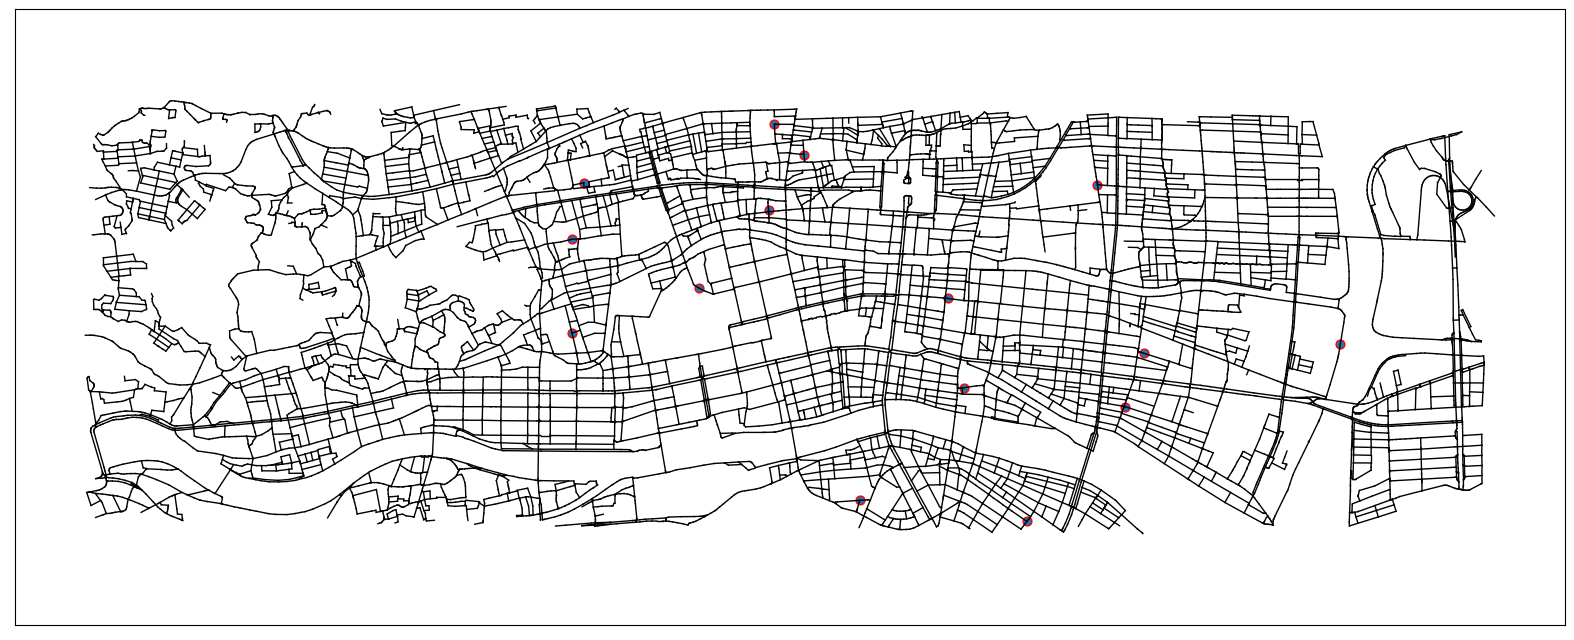

In [20]:
import matplotlib.pyplot as plt

plt.style.use('default')

linksdb = np.loadtxt('./data/linksdb.csv',delimiter=',')
nodesdb = np.loadtxt('./data/nodesdb.csv',delimiter=',')
pedDB = np.loadtxt('./data/agentsdb.csv',delimiter=',')
numPedestrian = pedDB.shape[0]
transLinkdb = np.loadtxt('./data/actionsdb.csv',delimiter=',')

colorNode = ["b","r"] 
plt.figure(num="Network",figsize=(20,8))
plt.tight_layout()
for i in range(linksdb.shape[0]):
    plt.plot([nodesdb[int(linksdb[i,1]),1], nodesdb[int(linksdb[i,2]),1]],[nodesdb[int(linksdb[i,1]),2], nodesdb[int(linksdb[i,2]),2]], c='k', lw=1)
    # plt.text(0.5*(nodesdb[int(linksdb[i,1]),1] + nodesdb[int(linksdb[i,2]),1]) , 0.5*(nodesdb[int(linksdb[i,1]),2] + nodesdb[int(linksdb[i,2]),2]), 
    #         "%d" % linksdb[i,0], fontsize=8, color='g')
# for i in range(self.nodesdb.shape[0]):
#     plt.text(self.nodesdb[i,1], self.nodesdb[i,2], self.nodesdb[i,0], fontsize = 7, color=colorNode[ int(self.nodesdb[i,3]) ])

# indxZeroActions = np.where(transLinkdb[:,1] == 0)[0]
# plt.scatter(nodesdb[indxZeroActions][:,1], nodesdb[indxZeroActions][:,2], s=20, edgecolor='r', linewidths=1.0)

indxshelter = np.where(nodesdb[:,3] == 1)[0]
plt.scatter(nodesdb[indxshelter][:,1], nodesdb[indxshelter][:,2], s=40, edgecolor='r', linewidths=1)

#plot agents
# ag = pedDB[:numPedestrian,4]
# hist, bin_edges = np.histogram(ag,density=False)
# norm = plt.Normalize()
# colors = plt.cm.jet(norm(hist))
# for n in ag_unique:
#     plt.scatter(nodesdb[int(n),1], nodesdb[int(n),2], s=10, c = "r", linewidth=1.0)
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.show()

# Reduce number of agents

In [ ]:
import numpy as np

#pickup N random agents
N = 300

agentsdb = np.loadtxt('./data/agentsdb.csv',delimiter=',')
nrows = agentsdb.shape[0]
rand_ind = np.random.choice(nrows,size=N,replace=False)
new_agentsdb = agentsdb[rand_ind,:]
np.savetxt(f"./data/{N}agentsdb.csv", new_agentsdb, delimiter=",", header="age,gender,hhType,hhId,Node",fmt="%d,%d,%d,%d,%d")
